In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [38]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [13]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [142]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [144]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [146]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)
session

# Exploratory Precipitation Analysis

In [120]:
# Print first row of data for 'station'
first_row_s = session.query(station).first()
first_row_s.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1670499f8f0>,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'latitude': 21.2716,
 'elevation': 3.0}

In [122]:
# Print first row of data for 'measurement'
first_row_m = session.query(measurement).first()
first_row_m.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1670499eb70>,
 'id': 1,
 'date': '2010-01-01',
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [124]:
# Find the most recent date in the data set.
recent_date_eq = session.query(measurement.date).order_by(desc(measurement.date)).first()
print(recent_date_eq)

('2017-08-23',)


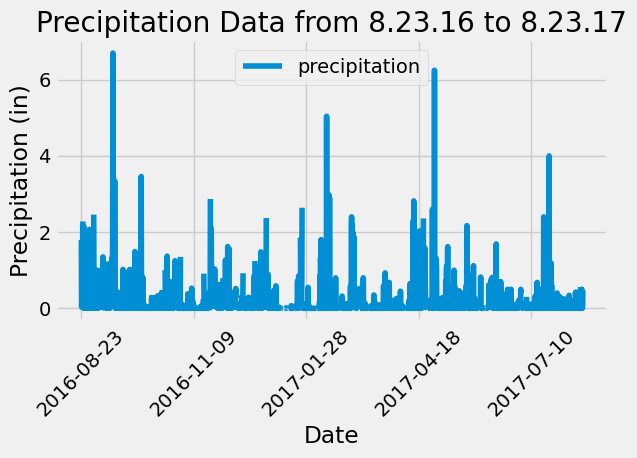

In [126]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database; Convert from sqlalchemy row data type to datetime data type
recent_date_str = recent_date_eq[0]  # Extract the date string from the Row object
recent_date = dt.datetime.strptime(recent_date_str, '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
start_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipition_data = session.query(measurement).filter(measurement.date >= start_date, measurement.date <= recent_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_data_dict = [{"date": row.date, "precipitation": row.prcp} for row in precipitation_data]
precipitation_data_df = pd.DataFrame(precipitation_data_dict)

# Sort the dataframe by date
precipitation_data_df = precipitation_data_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_data_df.plot(x='date', y='precipitation') #, figsize=(10, 6))
plt.title('Precipitation Data from 8.23.16 to 8.23.17')
plt.xlabel('Date')
plt.ylabel('Precipitation (in)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [138]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_data_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [154]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).all()
print(total_stations)

[(9,)]


In [194]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
                            group_by(measurement.station).\
                            order_by(func.count(measurement.station).desc()).\
                            limit(10).all()

# Display the stations with the most counts
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [202]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = 'USC00519281'
active_temp_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
filter(measurement.station == most_active_station).first()

# Display the calculated statistics
print(active_temp_stats)

(54.0, 85.0, 71.66378066378067)


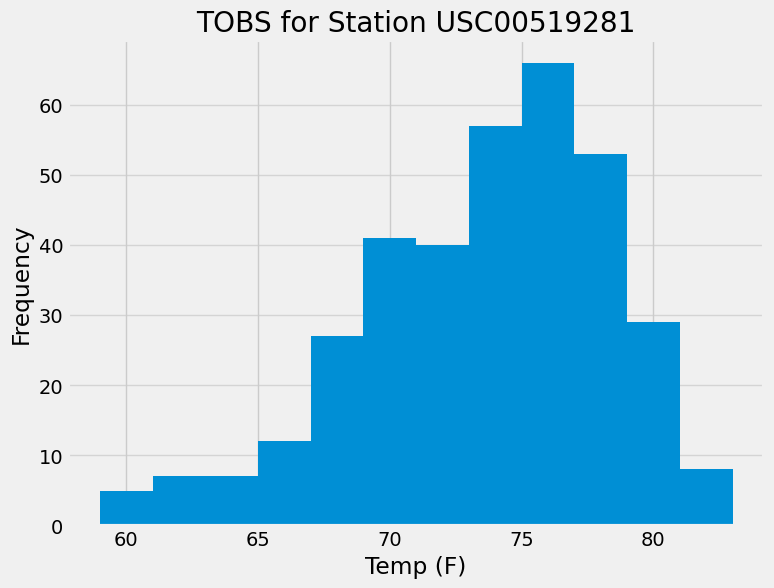

In [208]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == most_active_station).\
    filter(measurement.date >= start_date, measurement.date <= recent_date).all()

temp_values = [temp for date, temp in temp_data]

plt.figure(figsize=(8, 6))
plt.hist(temp_values, bins=12)
plt.xlabel('Temp (F)')
plt.ylabel('Frequency')
plt.title('TOBS for Station USC00519281')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Close Session

In [211]:
# Close Session
session.close()